In [4]:
import pandas as pd
from datetime import datetime
from pathlib import Path

In [5]:
df = pd.read_excel("./data/serie_ingresos.xlsx")

In [6]:
# Filtrar columnas que contienen "Precio Monómico"
precio_cols = [col for col in df.columns if "Precio Monómico" in col]
# Seleccionar solo esas columnas (+ columnas identificativas si lo deseas)
df_precios = df[["CENTRAL", "TECNOLOGIA"] + precio_cols]  # Opción con identificadores
df_precios.to_excel("./preprocess/serie_precios_monomico.xlsx", index=False)

In [7]:
# Identificar columnas de precios que empiezan con 'Precio Monómico USD/MWh'
precio_cols = [col for col in df.columns if col.startswith("Precio Monómico")]

# Transformar a formato largo
df_long = df.melt(
    id_vars=["CENTRAL", "TECNOLOGIA"],
    value_vars=precio_cols,
    var_name="MES",
    value_name="PRECIO_MONOMICO"
)
# Limpiar columna de fecha: extraer el mes y año del nombre de columna
df_long["MES"] = df_long["MES"].str.extract(r"(\d{6})")
df_long["FECHA"] = pd.to_datetime(df_long["MES"], format="%m%Y")

# Ordenar
df_long = df_long.sort_values(["CENTRAL", "FECHA"]).reset_index(drop=True)


In [8]:
# Paso 1: Transformar a formato largo
precio_cols = [col for col in df.columns if col.startswith("Precio Monómico")]
df_long = df.melt(
    id_vars=["CENTRAL", "TECNOLOGIA"],
    value_vars=precio_cols,
    var_name="MES",
    value_name="PRECIO_MONOMICO"
)

# Extraer mes y año en formato MMYYYY y convertir a fecha
df_long["MES"] = df_long["MES"].str.extract(r"(\d{6})")
df_long["FECHA"] = pd.to_datetime(df_long["MES"], format="%m%Y", errors="coerce")

# Eliminar filas sin fecha o sin valor numérico
df_long = df_long.dropna(subset=["FECHA", "PRECIO_MONOMICO"])

# Paso 2: Detección de outliers con el método IQR
Q1 = df_long["PRECIO_MONOMICO"].quantile(0.25)
Q3 = df_long["PRECIO_MONOMICO"].quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = df_long[(df_long["PRECIO_MONOMICO"] < lower_bound) | (df_long["PRECIO_MONOMICO"] > upper_bound)]

In [9]:
# Crear una serie temporal sin outliers
df_sin_outliers = df_long[
    (df_long["PRECIO_MONOMICO"] >= lower_bound) &
    (df_long["PRECIO_MONOMICO"] <= upper_bound)
].copy()

# Verificamos dimensiones antes y después
original_shape = df_long.shape
filtered_shape = df_sin_outliers.shape

original_shape, filtered_shape

((999, 5), (930, 5))

In [10]:
df_long.groupby("CENTRAL")["PRECIO_MONOMICO"].mean().sort_values(ascending=False).head(10)

CENTRAL
CHACO ENERGIAS S.A.    201.254953
C. El Alto             171.182633
Corani                 128.923449
Misicuni VHE           114.231933
Yunchara                97.587160
San Jacinto             96.243895
Yunchará                95.389924
Eólica Warnes           86.056336
Kanata VHE              71.581360
Valle Hermoso           66.261900
Name: PRECIO_MONOMICO, dtype: float64

In [11]:
df_sin_outliers.groupby(["FECHA","CENTRAL"])["PRECIO_MONOMICO"].mean().head(10)

FECHA       CENTRAL            
2023-01-01  Aranjuez               35.371500
            C. El Alto             15.400127
            CHACO ENERGIAS S.A.    83.190749
            Corani                 92.370678
            Cumbre                 29.043902
            Del Sur                27.099947
            Entre Ríos II          22.983144
            Eólica El Dorado       56.003610
            Eólica San Julián      57.158847
            Eólica Warnes          78.354212
Name: PRECIO_MONOMICO, dtype: float64

In [12]:
df_merge = df_long.merge(df_sin_outliers, on=["CENTRAL", "FECHA"], suffixes=('_original', '_sin_outliers'))

In [14]:
df_merge.head()

,CENTRAL,TECNOLOGIA_original,MES_original,PRECIO_MONOMICO_original,FECHA,TECNOLOGIA_sin_outliers,MES_sin_outliers,PRECIO_MONOMICO_sin_outliers
0,Aranjuez,Termo,012023,35.371500,2023-01-01,Termo,012023,35.371500
1,C. El Alto,Termo,012023,15.400127,2023-01-01,Termo,012023,15.400127
2,CHACO ENERGIAS S.A.,Termo,012023,83.190749,2023-01-01,Termo,012023,83.190749
3,Corani,Hidro,012023,92.370678,2023-01-01,Hidro,012023,92.370678
4,Cumbre,Hidro,012023,29.043902,2023-01-01,Hidro,012023,29.043902


In [15]:
df_merge.columns

Index(['CENTRAL', 'TECNOLOGIA_original', 'MES_original',
       'PRECIO_MONOMICO_original', 'FECHA', 'TECNOLOGIA_sin_outliers',
       'MES_sin_outliers', 'PRECIO_MONOMICO_sin_outliers'],
      dtype='object')

In [13]:
import pandas as pd

# Subconjunto de columnas
subset = ['CENTRAL','FECHA', 'TECNOLOGIA_sin_outliers','PRECIO_MONOMICO_sin_outliers']
df_comp = df_merge[subset].copy()
df_comp.columns = ["CENTRAL", "FECHA", "TECNOLOGIA",  "PRECIO_MONOMICO"]
df_comp["FECHA"] = pd.to_datetime(df_comp["FECHA"], format="%Y-%m-%d")

In [14]:
df_comp.head()

,CENTRAL,FECHA,TECNOLOGIA,PRECIO_MONOMICO
0,Aranjuez,2023-01-01,Termo,35.371500
1,C. El Alto,2023-01-01,Termo,15.400127
2,CHACO ENERGIAS S.A.,2023-01-01,Termo,83.190749
3,Corani,2023-01-01,Hidro,92.370678
4,Cumbre,2023-01-01,Hidro,29.043902


In [15]:
df_comp.to_excel("./preprocess/comparacion_precios_monomico.xlsx", index=False)

In [16]:
import pandas as pd

# Cargar la comparación ya procesada
df_comp = pd.read_excel("./preprocess/comparacion_precios_monomico.xlsx")

# Asegurar que FECHA esté en formato datetime
df_comp["FECHA"] = pd.to_datetime(df_comp["FECHA"])

# Crear columna de MES en formato MMYYYY
df_comp["MES"] = df_comp["FECHA"].dt.strftime("%m%Y")

# Crear nombre de columna
df_comp["col_name"] = "Precio Monómico USD/MWh " + df_comp["MES"]

# Pivotear
df_pivot = df_comp.pivot_table(
    index=["CENTRAL", "TECNOLOGIA"],
    columns="col_name",
    values="PRECIO_MONOMICO"
).reset_index()

# Ordenar las columnas por fecha real, extrayendo MMYYYY al final del nombre
def extract_date(col):
    if col.startswith("Precio Monómico"):
        return pd.to_datetime(col[-6:], format="%m%Y")
    return pd.NaT  # Para columnas que no tienen fecha

# Obtener y ordenar columnas
fixed_cols = ["CENTRAL", "TECNOLOGIA"]
date_cols = sorted(
    [col for col in df_pivot.columns if col.startswith("Precio Monómico")],
    key=extract_date
)

# Reordenar el DataFrame
df_pivot = df_pivot[fixed_cols + date_cols]

# Guardar en Excel
df_pivot.to_excel("./data/precios_monomico.xlsx", index=False)



In [25]:
df = pd.read_excel("./data/precios_monomico.xlsx")

In [26]:
df.head()  # Mostrar las primeras filas del DataFrame para verificar los cambios

,CENTRAL,TECNOLOGIA,Precio Monómico USD/MWh 012023,Precio Monómico USD/MWh 012024,Precio Monómico USD/MWh 012025,Precio Monómico USD/MWh 022023,Precio Monómico USD/MWh 022024,Precio Monómico USD/MWh 022025,Precio Monómico USD/MWh 032023,Precio Monómico USD/MWh 032024,...,Precio Monómico USD/MWh 082023,Precio Monómico USD/MWh 082024,Precio Monómico USD/MWh 092023,Precio Monómico USD/MWh 092024,Precio Monómico USD/MWh 102023,Precio Monómico USD/MWh 102024,Precio Monómico USD/MWh 112023,Precio Monómico USD/MWh 112024,Precio Monómico USD/MWh 122023,Precio Monómico USD/MWh 122024
0,Aguai (Autoproductor),Biomasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.847456,27.944646,40.543720,32.657733,NaN,32.583704,30.887298,29.843698,NaN,NaN
1,Aguaí Energia,Biomasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.664361,29.050808,28.353250,33.174628,28.895618,32.296460,30.198955,29.982228,NaN,NaN
2,Aranjuez,Termo,35.371500,36.306033,NaN,37.432971,37.519038,109.830757,35.311747,36.333967,...,35.838134,39.431440,37.311992,38.943096,36.549939,38.366914,36.431863,42.589325,36.763232,90.353307
3,C. El Alto,Termo,15.400127,31.174574,NaN,15.319300,41.281202,NaN,15.348441,NaN,...,22.285252,15.648143,28.524680,16.101862,29.049061,20.773135,26.196140,31.066200,36.070616,NaN
4,CHACO ENERGIAS S.A.,Termo,83.190749,20.286122,NaN,NaN,20.518697,NaN,42.785507,95.693806,...,NaN,57.806994,NaN,23.458216,77.537323,29.508210,20.215046,NaN,22.280926,NaN


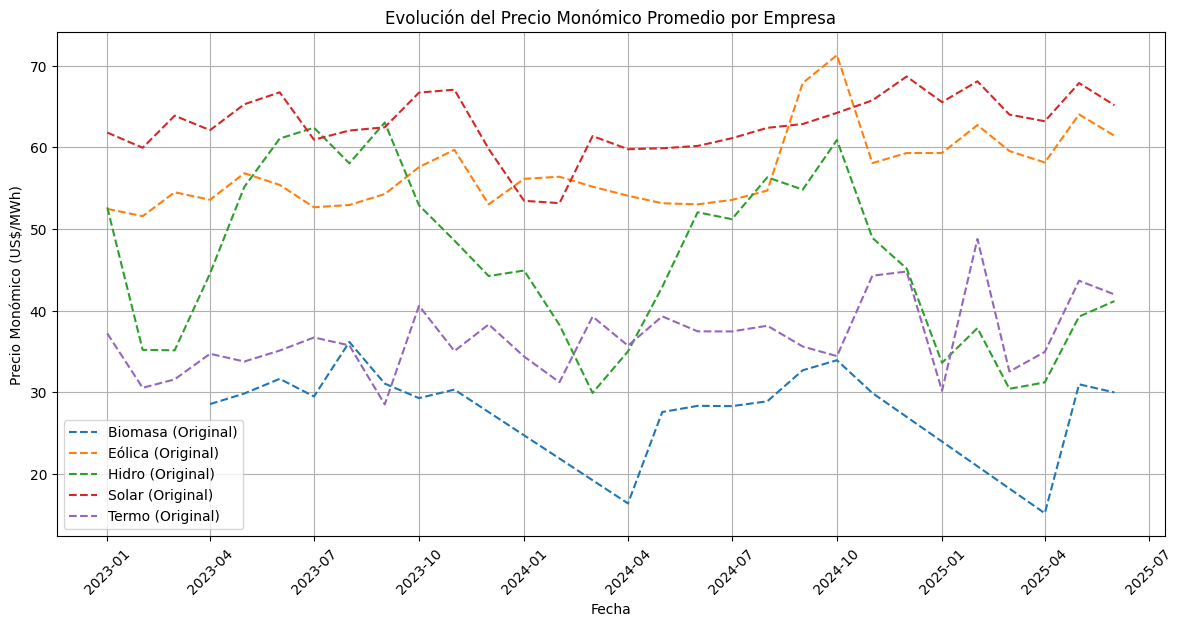

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar el archivo Excel
ruta_archivo = "./preprocess/comparacion_precios_monomico.xlsx"
df = pd.read_excel(ruta_archivo)

# 2. Asegurar que la columna FECHA esté en formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# 3. Calcular el promedio mensual de precios por EMPRESA
# Agrupamos por empresa y fecha
df_grouped = df.groupby(['TECNOLOGIA', 'FECHA']).agg({
    'PRECIO_MONOMICO': 'mean',
}).reset_index()

# 4. Graficar evolución temporal de precios por empresa
empresas = df_grouped['TECNOLOGIA'].unique()

plt.figure(figsize=(12, 6))

for empresa in empresas:
    df_empresa = df_grouped[df_grouped['TECNOLOGIA'] == empresa]
    plt.plot(df_empresa['FECHA'], df_empresa['PRECIO_MONOMICO'], label=f"{empresa} (Original)", linestyle='--')
    #plt.plot(df_empresa['FECHA'], df_empresa['PRECIO_MONOMICO_sin_outliers'], label=f"{empresa} (Sin outliers)", linestyle='-')

plt.title("Evolución del Precio Monómico Promedio por Empresa")
plt.xlabel("Fecha")
plt.ylabel("Precio Monómico (US$/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [20]:
df_sin_outliers.to_excel("./data/serie_precios_sin_outliers.xlsx", index=False)

In [22]:
df_sin_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   AGENTE           1994 non-null   object        
 1   EMPRESA          1994 non-null   object        
 2   MES              1994 non-null   object        
 3   PRECIO_MONOMICO  1994 non-null   float64       
 4   FECHA            1994 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 93.5+ KB
